# X-Ray Analysis

General analysis of all the features we've identified in prior notbeooks

In [39]:
#system
from __future__ import division
import sys
import os
import glob
import re

#numpy
import numpy as np
import scipy
import pandas as pd

#astropy
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.patches import Ellipse

import pyregion

#import aplpy
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm

In [2]:
#About A2597
name = 'Abell 2597'
rah, decd = '23h25m19.7s', '-12d07m27s'
coord = SkyCoord(rah, decd, frame='icrs')
ra = coord.ra.degree
dec = coord.dec.degree
radius = Angle(20, u.arcsec)

z = 0.0821 #z selected from Tremblay (2018)
cz = z * const.c.to('km/s') # The stellar systemic velocity 

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(z)
dl = cosmo.luminosity_distance(z)

angular_diameter_distance = cosmo.angular_diameter_distance(z=z) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)

#cccpiv fits
r500 = 904.8 * u.kpc 

print(f"RA: {ra}, DEC: {dec}, kpc_per_arcsec: {kpc_per_arcsec}, \n r500: {r500}, z: {z}, cz: {cz}")

RA: 351.33208333333334, DEC: -12.124166666666667, kpc_per_arcsec: 1.5268136461177872 kpc / arcsec, 
 r500: 904.8 kpc, z: 0.0821, cz: 24612.9608018 km / s


In [35]:
starting_dir = '/Users/osaseomoruyi/research/a2597/chandra/'
obsID_dir = os.path.join(starting_dir, 'obsIDs/')
joint_analysis_dir = os.path.join(starting_dir, 'joint_analysis/')

specfit_savepath = 'spectral_profiles/'

## Cavity Energy

### Calculate Bouaynt Rise times for Each Cavity

In [19]:
cavity_names = ['Total SW Ghost Cavity', 'Broken off Piece of SW Ghost Cavity', 'Northeastern G.C.',  'Outer Northeastern Ghost Cavity', 'NE Filament Base Cavity', 'Eastern Ghost Cavity']#, 'SW Tunnel/ Network of Small Cavities']

cavity_rmajors = [10.876, 14.479, 5.362, 6.788, 2.339, 4.498] * u.arcsec * kpc_per_arcsec 
cavity_rminors = [4.720, 3.830, 5.362, 5.150, 2.339, 3.001] * u.arcsec * kpc_per_arcsec 

cav_diameters = cavity_rmajors * 2

distances_from_peak = [14.423, 18.176, 14.103, 21.498, 4.954, 10.687] * u.arcsec * kpc_per_arcsec

In [42]:
np.mean(cav_diameters)

<Quantity 22.56732357 kpc>

In [22]:
for idc, cav_name in enumerate(cavity_names):
    print(f"\n{cav_name} has rmajor = {cavity_rmajors[idc]:.1f}, rminor = {cavity_rminors[idc]:.1f}, distance from peak = {distances_from_peak[idc]:.1f}")


Total SW Ghost Cavity has rmajor = 16.6 kpc, rminor = 7.2 kpc, distance from peak = 22.0 kpc

Broken off Piece of SW Ghost Cavity has rmajor = 22.1 kpc, rminor = 5.8 kpc, distance from peak = 27.8 kpc

Northeastern G.C. has rmajor = 8.2 kpc, rminor = 8.2 kpc, distance from peak = 21.5 kpc

Outer Northeastern Ghost Cavity has rmajor = 10.4 kpc, rminor = 7.9 kpc, distance from peak = 32.8 kpc

NE Filament Base Cavity has rmajor = 3.6 kpc, rminor = 3.6 kpc, distance from peak = 7.6 kpc

Eastern Ghost Cavity has rmajor = 6.9 kpc, rminor = 4.6 kpc, distance from peak = 16.3 kpc


In [25]:
def cavity_age(distance_to_cavity, cross_area_cavity, volume_cavity, sigma, C=0.75, gamma=5./3., kT=2.5*u.keV, mu=0.62):
    """
    Calculate the cavity age of an ellipsoidal cavity in the ICM.

    Parameters
    ----------
    distance_to_cavity : float
        Projected distance from the center of the cavity to the BCG center [kpc].
    cross_area_cavity : float
        Projected cross-sectional area of the cavity [kpc^2].
    volume_cavity : float
        Projected volume of the cavity [kpc^3].
    sigma : float
        Stellar velocity dispersion of the BCG [km/s].
    C : float, optional
        Drag coefficient, default to 0.75.
    kT : float, optional
        Temperature of the ICM near edge of cavity [keV], default to 2.3.

    Returns
    -------
    t_cav : float
        Cavity age [Myr].
    """
    #calculate the gravitational acceleration
    g = 2 * sigma**2 / distance_to_cavity  # Gravitational acceleration [cm/s^2]
    print(f"Gravitational acceleration: {g.cgs:.2e}")

    #calculate the sound speed
    v_sound = np.sqrt((gamma * kT)/(mu * const.m_p)) 
    print(f"Sound speed: {v_sound.to(u.km/u.s):.1f}")

    #calculate terminal velocity
    v_term = np.sqrt(2*g*volume_cavity/(C*cross_area_cavity)) #
    print(f"Terminal velocity:{v_term.to(u.km/u.s):.1f}")

    #calculate the cavity age
    t_cav = distance_to_cavity /v_term   # Cavity age [s]
    print(f"assuming the cavity rose at the terminal speed, the age of the cavity is: {t_cav.to(u.Myr):.1f}")

    t_cav_sound = distance_to_cavity / v_sound
    print(f"assuming the cavity rose at the sound speed, the age of the cavity is: {t_cav_sound.to(u.Myr):.1f}")
    
    return t_cav, t_cav_sound

In [26]:
sigma_a2597 = 350 * u.km/u.s #tremblay 2018, muse map figure 11
cav_tsound = []
cav_tbuoy = []
cav_volumes = []
for idc, cav_name in enumerate(cavity_names):
    print(f"{cav_name}")
    ra, rb = cavity_rmajors[idc], cavity_rminors[idc]

    distance_to_cavity = distances_from_peak[idc]
    # if rb == 0:
    #     cross_area_cavity = np.pi * ra**2
    #     volume_cavity = 4/3 * np.pi * ra**3
    # else:
    cross_area_cavity = np.pi * ra * rb
    volume_cavity = 4/3 * np.pi * ra * rb**2
    
    cav_volumes.append(volume_cavity)
        
    print(f"cross area: {cross_area_cavity:.2f}, volume: {volume_cavity:.2f}")
    t_cav, t_cav_sound = cavity_age(distance_to_cavity, cross_area_cavity, volume_cavity, sigma_a2597)
    cav_tsound.append(t_cav_sound.to(u.yr).value)
    cav_tbuoy.append(t_cav.to(u.yr).value)

    print("\n")

Total SW Ghost Cavity
cross area: 375.95 kpc2, volume: 3612.43 kpc3
Gravitational acceleration: 3.61e-08 cm / s2
Sound speed: 802.3 km / s
Terminal velocity:533.9 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 40.3 Myr
assuming the cavity rose at the sound speed, the age of the cavity is: 26.8 Myr


Broken off Piece of SW Ghost Cavity
cross area: 406.12 kpc2, volume: 3166.52 kpc3
Gravitational acceleration: 2.86e-08 cm / s2
Sound speed: 802.3 km / s
Terminal velocity:428.4 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 63.3 Myr
assuming the cavity rose at the sound speed, the age of the cavity is: 33.8 Myr


Northeastern G.C.
cross area: 210.56 kpc2, volume: 2298.41 kpc3
Gravitational acceleration: 3.69e-08 cm / s2
Sound speed: 802.3 km / s
Terminal velocity:575.5 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 36.6 Myr
assuming the cavity rose at the sound speed, the age of the cavity 

#### Cross Checkw ith T12b

In [19]:
# Label Name (kpc) (kpc) (× 1057 erg) (× 107 yr) (× 107 yr) (× 107 yr) (× 1042 erg s−1) (1) (2) (3) (4) (5) (6) (7) (8) (9) 1+2 Western ‘large cavity’ 9 9 35.9 1.0 1.4 5.6 170.6 3 M01 northern ‘ghost’ cavity 21 6.6 7.0 2.7 6.1 7.3 16.5 4 Eastern ‘ghost’ cavity 35 3.6 0.79 3.8 17.8 6.9 1.05 6 Filament base cavity 9 2.3 0.30 1.1 2.7 2.8 1.73

t12_names = ['Western Large Cavity', 'Northern Ghost Cavity', 'Eastern Ghost Cavity', 'Filament Base Cavity']
t12_rd = [9, 21, 35, 9]
t12_rad = [9, 6.6, 3.6, 2.3]

In [24]:
sigma_a2597 = 350 * u.km/u.s #tremblay 2018, muse map figure 11
t12_cav_tsound = []
t12_cav_tbuoy = []

for idc, cav_name in enumerate(t12_names):
    print(f"{cav_name}")
    distance_to_cavity = t12_rd[idc] * u.kpc
    rad_cav = t12_rad[idc] * u.kpc
    cross_area_cavity = np.pi * rad_cav**2
    volume_cavity = 4/3 * np.pi * rad_cav**3
        
    print(f"cross area: {cross_area_cavity:.2f}, volume: {volume_cavity:.2f}")
    t_cav, t_cav_sound = cavity_age(distance_to_cavity, cross_area_cavity, volume_cavity, sigma_a2597)
    t12_cav_tsound.append(t_cav_sound.to(u.yr).value)
    t12_cav_tbuoy.append(t_cav.to(u.yr).value)

    print("\n")

Western Large Cavity
cross area: 254.47 kpc2, volume: 3053.63 kpc3
Gravitational acceleration: 8.82e-08 cm / s2
Sound speed: 802.33 km / s
Terminal velocity:933.33 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 9.43 Myr
assuming the cavity rose at the sound speed, the age of the cavity is: 10.97 Myr


Northern Ghost Cavity
cross area: 136.85 kpc2, volume: 1204.26 kpc3
Gravitational acceleration: 3.78e-08 cm / s2
Sound speed: 802.33 km / s
Terminal velocity:523.24 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 39.24 Myr
assuming the cavity rose at the sound speed, the age of the cavity is: 25.59 Myr


Eastern Ghost Cavity
cross area: 40.72 kpc2, volume: 195.43 kpc3
Gravitational acceleration: 2.27e-08 cm / s2
Sound speed: 802.33 km / s
Terminal velocity:299.33 km / s
assuming the cavity rose at the terminal speed, the age of the cavity is: 114.33 Myr
assuming the cavity rose at the sound speed, the age of the cavity is:

### Cavity Power and Energy

In [52]:
def cavity_power(volume_cavity, pressure_cavity, age_cav):
    """
    Calculate the cavity power of an ellipsoidal cavity in the ICM.

    Parameters
    ----------
    distance_to_cavity : float
        Projected distance from the center of the cavity to the BCG center [kpc].
    cross_area_cavity : float
        Projected cross-sectional area of the cavity [kpc^2].
    volume_cavity : float
        Projected volume of the cavity [kpc^3].
    pressure_cav : float
        pressure of outer edges of cavity [dyne/cm^2].
    sigma : float
        Stellar velocity dispersion of the BCG [km/s].
    C : float, optional
        Drag coefficient, default to 0.75.
    Returns
    -------
    P_cav : float
        Cavity power [erg/s].
    """
    #calculate the cavity energy
    E_cav = pressure_cavity * volume_cavity  # Cavity energy [erg]
    #print(f"pressure_cavity: {pressure_cavity}, volume_cavity: {volume_cavity}")
    print(f"the energy required to create the cavity is: {E_cav.to(u.erg)/1e57:.1f} * 10^57 ")

    print(f"Cavity enthalpy 4pV = {4*E_cav.to(u.erg)/1e58:.1f} * 10^58 ")

    #calculate the cavity power
    P_cav = 4 * E_cav / age_cav  # Cavity power [erg/s]
    print(f"the power exerted by the rising cavity is: {P_cav.to(u.erg/u.s)/1e43:.1f} * 10^43")
    
    return E_cav.to(u.erg), P_cav.to(u.erg/u.s)


In [ ]:
#get cav pressures from cav profile

#load ccpiv profiles
profiles_path = glob.glob(specfit_savepath + '*020125*.npy')[0]

by_hand_profs = pd.DataFrame(np.load(profiles_path, allow_pickle=True))

kTs = by_hand_profs['kT'].to_numpy() * u.keV

norms = by_hand_profs['norm'].to_numpy()

radius = by_hand_profs['radius'].to_numpy() * u.kpc


r_inner_in_kpc = by_hand_profs['r_inner'].to_numpy() * u.kpc
r_outer_in_kpc = by_hand_profs['r_outer'].to_numpy() * u.kpc


volume = (4/3) * np.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

#electron density
electron_density = np.sqrt((norms * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + z), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 
#pressure
pressures = (2 * electron_density * kTs).to(u.dyne/u.cm**2)


cav_distances = (distances_from_peak).to(u.kpc).value
cav_pressures = np.interp(cav_distances, radius.value, pressures.value) * u.dyne/u.cm**2
# cav_pressures = cp_pressures_interp(cav_distances)



NameError: name 'distances_from_peak' is not defined

In [54]:
energy_cavs = []
power_cavs = []

for idc, cav_name in enumerate(cavity_names):
    print(f"{cav_name}")
    ra, rb = cavity_rmajors[idc], cavity_rminors[idc]
    pressure_cavity = cav_pressures[idc] 

    cross_area_cavity = np.pi * ra * rb
    rc = rb
    volume_cavity = 4/3 * np.pi * ra * rb * rc
    
    age_cav = np.mean([cav_tbuoy[idc], cav_tsound[idc]]) * u.yr
    #print(f"cross area: {cross_area_cavity:.2f}, volume: {volume_cavity:.2f}, pressure: {pressure_cavity:.2e}, distance: {distance_to_cavity:.2f}")
    E_cav, P_cav = cavity_power(volume_cavity, pressure_cavity, age_cav)
    energy_cavs.append(E_cav.value)
    power_cavs.append(P_cav.value)

    print("\n")

Total SW Ghost Cavity
the energy required to create the cavity is: 47.8 erg * 10^57 
Cavity enthalpy 4pV = 19.1 erg * 10^58 
the power exerted by the rising cavity is: 18.1 erg / s * 10^43


Broken off Piece of SW Ghost Cavity
the energy required to create the cavity is: 35.3 erg * 10^57 
Cavity enthalpy 4pV = 14.1 erg * 10^58 
the power exerted by the rising cavity is: 9.2 erg / s * 10^43


Northeastern G.C.
the energy required to create the cavity is: 30.9 erg * 10^57 
Cavity enthalpy 4pV = 12.4 erg * 10^58 
the power exerted by the rising cavity is: 12.5 erg / s * 10^43


Outer Northeastern Ghost Cavity
the energy required to create the cavity is: 26.0 erg * 10^57 
Cavity enthalpy 4pV = 10.4 erg * 10^58 
the power exerted by the rising cavity is: 6.0 erg / s * 10^43


NE Filament Base Cavity
the energy required to create the cavity is: 4.9 erg * 10^57 
Cavity enthalpy 4pV = 2.0 erg * 10^58 
the power exerted by the rising cavity is: 6.0 erg / s * 10^43


Eastern Ghost Cavity
the ene

In [41]:
(47.8 + 35.3 + 30.9 + 26 +4.9 + 9.9) * 1e57/4e59

0.38700000000000007

#### Can the sum of the cavity powers offset raidative cooling?

In [109]:
lcool = 1e44 * u.erg/u.s
pcavs = power_cavs 
sum_pcav = np.sum(pcavs) * u.erg/u.s

print(f"The cooling luminosity is: {lcool:.2e}")
print(f"The total cavity power is: {sum_pcav:.2e}")

The cooling luminosity is: 1.00e+44 erg / s
The total cavity power is: 1.46e+44 erg / s


### Cold vs Hot Accretion Fuel

#### Bondi Accretion (Hot Fueling)

In [25]:
def M_sigma_relation(sigma):
    """ 
    Calculate sthe mass of the SMBH using the M-sigma relation from McConnell et al. 2011.
    """
    log_mbh = 8.38  + 4.53 * np.log10(sigma/(200*u.km/u.s))
    # mbh = 1e8 * u.solMass * 1.9 * (sigma/(200*u.km/u.s))**5.1
    return 10**log_mbh * u.solMass

The median stellar velocity within the nucleus is about 290 km/s (Tremblay 2018)

In [26]:
sigma = 290 * u.km/u.s #mean velocity dispersion from tremblay 2018 in the nucleus

print(f"the mass of the SMBH in Abell 2597 is: {M_sigma_relation(sigma):.2e}")


the mass of the SMBH in Abell 2597 is: 1.29e+09 solMass


Need to extrapolate values down to Bondi radius

In [28]:
def bondi_accretion_rate(T_kev, n_e, mbh):
    """ 
    equation 2 of bambic et al 2023
    """
    parta = np.power(T_kev/u.keV, -3/2)
    partb = np.power(mbh / 1e9 * u.solMass, 2)
    mdot_bondi = 0.012 * parta * (n_e/u.cm**-3) * partb
    return mdot_bondi.value * u.solMass/u.yr

T_keV = 2.23 * u.keV 
n_e =0.2* u.cm**-3 # 0.075914712 * u.cm**-3
mbh = M_sigma_relation(sigma)

print(f"the mass of the balck hole is: {mbh:.2e}")
# R_B = \frac{2GM_{BH}}{c_s^2}
gamma, mu =5./3., 0.62
c_s = np.sqrt((gamma * T_keV)/(mu * const.m_p)) 
r_bondi = (2 * const.G * mbh / (c_s**2)).to(u.kpc)
finest_radius = 0.5 * u.arcsec * kpc_per_arcsec
print(f"the bondi radius is: {r_bondi.to(u.pc):.2f} but the finest radius chandra can resolve is is: {finest_radius.to(u.pc):.2f}")



the mass of the balck hole is: 1.29e+09 solMass
the bondi radius is: 19.34 pc but the finest radius chandra can resolve is is: 763.41 pc


In [ ]:
#by hand profiles
profiles_path = specfit_savepath + 'by_hand_profiles_tprof_sphere.npy'

by_hand_profs = pd.DataFrame(np.load(profiles_path))

flux = by_hand_profs['flux'].to_numpy() * u.erg / (u.cm**2 * u.s)
flux_upp_err = by_hand_profs['flux_up_err'].to_numpy() * u.erg / (u.cm**2 * u.s)
flux_low_err = by_hand_profs['flux_low_err'].to_numpy() * u.erg / (u.cm**2 * u.s)

#KT and norm
kTs = by_hand_profs['kT'].to_numpy() * u.keV
kT_upp_errs = by_hand_profs['kT_up_err'].to_numpy() * u.keV
kT_low_errs = by_hand_profs['kT_low_err'].to_numpy() * u.keV
#kT_errs = by_hand_profs['kT_err'].to_numpy() * u.keV

norms = by_hand_profs['norm'].to_numpy()
norm_upp_errs = by_hand_profs['norm_up_err'].to_numpy()
norm_low_errs = by_hand_profs['norm_low_err'].to_numpy()

radius_to_plot = by_hand_profs['radius'].to_numpy() * u.kpc
radius_err_to_plot = by_hand_profs['radius_err'].to_numpy() * u.kpc

r_inner_in_kpc = by_hand_profs['r_inner'].to_numpy() * u.kpc
r_outer_in_kpc = by_hand_profs['r_outer'].to_numpy() * u.kpc


volume = (4/3) * np.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

#electron density
electron_density = np.sqrt((norms * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + z), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 


Density at Bondi radius (rB = 0.021 kpc) using Beta-model: 0.11 cm^-3


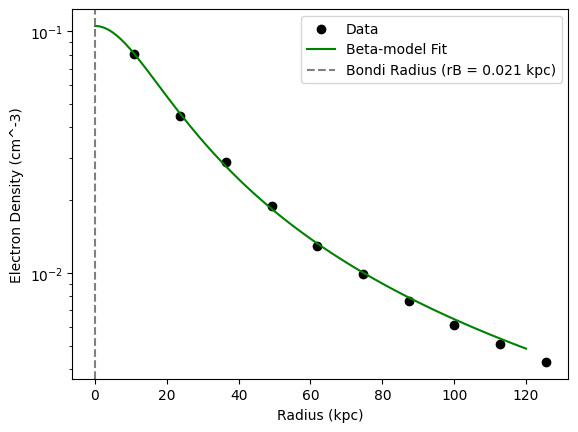

In [ ]:
from scipy.optimize import curve_fit
r_data = radius_to_plot.value[:10]#, electron_density.valuenp.array([1, 2, 3, 4, 5, 6])  # Replace with actual radial distance values
n_e_data = electron_density.value[:10] #np.array([1000, 800, 600, 500, 400, 350])  # Replace with actual density values

rB = 0.021  # Example value, replace with actual Bondi radius in kpc

def beta_model(r, n0, rc, beta):
    """Beta model: n_e = n0 * [1 + (r / rc)^2]^(-3 * beta / 2)"""
    return n0 * (1 + (r / rc)**2)**(-3 * beta / 2)

popt_beta, _ = curve_fit(beta_model, r_data, n_e_data)

# Extrapolate the density at the Bondi radius (rB)
n_e_rB_beta = beta_model(rB, *popt_beta)

print(f"Density at Bondi radius (rB = {rB} kpc) using Beta-model: {n_e_rB_beta:.2f} cm^-3")

# Plot the original data and the fitted models
r_fit = np.linspace(0.01, 120, 100)  # Extended range for plotting

plt.scatter(r_data, n_e_data, label='Data', color='black')
plt.plot(r_fit, beta_model(r_fit, *popt_beta), label='Beta-model Fit', color='green')

plt.axvline(x=rB, linestyle='--', color='gray', label=f'Bondi Radius (rB = {rB} kpc)')
plt.xlabel('Radius (kpc)')
plt.ylabel('Electron Density (cm^-3)')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
ne_bondi = 0.11 * u.cm**-3
tkev_bondi = 2.23 / 4
mdot_bondi = bondi_accretion_rate(tkev_bondi, ne_bondi, mbh)

print(f"the bondi accretion rate is: {mdot_bondi:.2e}")

the bondi accretion rate is: 5.29e-03 solMass / yr


In [ ]:
def eddington_accretion_rate(mbh):
    """
    Calculate the Eddington accretion rate of a SMBH. Rafferty (2006)
    """
    epsilon = 0.1   
    mdot_edd = 2.2 * np.power(epsilon, -1) * (mbh/(1e9 * u.solMass))
    return mdot_edd * u.solMass/u.yr

In [ ]:
print(f"the eddington accretion rate is: {eddington_accretion_rate(mbh):.2e}")

the eddington accretion rate is: 2.84e+01 solMass / yr


In [ ]:
def cavity_accretion_rate(pcav, epsilon=0.1):
    """ 
    Calculate the accretin rate of the SMBH based on the cavity power.
    Rafferty 2006
    """
    return (pcav / (epsilon * const.c**2)).to(u.solMass/u.yr)

min_cav_power = 6.6e41 * u.erg/u.s
max_cav_power = 1.2e43 * u.erg/u.s

print(f"the minimum accretion rate is: {cavity_accretion_rate(min_cav_power):.2e}")
print(f"the maximum accretion rate is: {cavity_accretion_rate(max_cav_power):.2e}")


the minimum accretion rate is: 1.17e-04 solMass / yr
the maximum accretion rate is: 2.12e-03 solMass / yr


### Cavity Power vs Bondi Accretion Rate

Figure 11 of Russel (2013)

In [ ]:
def power_bondi(mdot_bondi, eta=0.1):
    """ 
    The maximum power released from the SMBH within the Bondi radius
    Allen et al (2006)
    """
    return (eta * const.c**2 * mdot_bondi).to(u.erg/u.s)

In [ ]:
m87_mb = bondi_accretion_rate(1 * u.keV, 0.1 /u.cm**3, 1.3e9 * u.solMass)
print(f"the accretion rate in M87 is: {m87_mb:.2e}")
print(f"the power released from the SMBH in M87 is: {power_bondi(m87_mb):.2e}")

the accretion rate in M87 is: 2.03e-03 solMass / yr
the power released from the SMBH in M87 is: 1.15e+43 erg / s


In [ ]:
m87_mb = bondi_accretion_rate(0.5 * u.keV, 0.23 /u.cm**3, 6.6e9 * u.solMass)
print(f"the accretion rate in M87 is: {m87_mb:.2e}")
print(f"the power released from the SMBH in M87 is: {power_bondi(m87_mb):.2e}")

the accretion rate in M87 is: 3.40e-01 solMass / yr
the power released from the SMBH in M87 is: 1.93e+45 erg / s


In [ ]:
a2597_pbondi = power_bondi(mdot_bondi, eta=0.1)
pcav_sum = 1e44 * u.erg/u.s
print(f"the maximum power released from the SMBH within the Bondi radius is: {a2597_pbondi:.2e}")

the maximum power released from the SMBH within the Bondi radius is: 2.99e+43 erg / s


In [18]:
def convert_string_data(string_data):
    data_lines = string_data.strip().split('\n')[1:]

    # Initialize lists to store x and y data
    x_values = []
    y_values = []

    # Loop through each line, split by comma, and append to lists
    for line in data_lines:
        x, y = line.split(',')
        x_values.append(float(x))
        y_values.append(float(y))

        # Convert lists to numpy arrays
    x_array = np.array(x_values)
    y_array = np.array(y_values)
    return x_array, y_array

In [19]:
r13_bondi_cav_txt = """
x, y
0.026905197692822253, 0.3817843179454985
0.026864952996457817, 0.47833564313937504
0.027004154044990306, 0.5881373381633569
0.03263677492353232, 1.0449310384641204
0.03343046010984984, 4.89540998982161
0.03334260824530138, 8.66373983274223
0.07295329798286052, 0.6136973794881162
0.07185005194173738, 1.0806553693620748
0.07086442071695273, 1.5062924722136606
0.09343577179239071, 1.1465718308778505
0.09448633438892576, 4.716527404846012
0.09187186828832078, 8.554600534053014
0.06922539843090529, 5.512347508691212
0.07026628914872013, 8.91447201830493
0.07026628914872013, 11.520043218726338
0.11103470242287596, 11.34691699896964
0.10839864485793635, 12.765564187011877
0.10952740764509197, 14.320301906367929
0.5759581846836541, 3.4719609600906707
0.5920627662904744, 5.165109705736748
0.5838563179177191, 6.888034137928491
0.8671106854980097, 1.5941110778396628
0.8714773598086851, 3.5973925722872986
0.8614348652878029, 5.60860000563318
1.9039337893796002, 3.9352647439549333
1.8814443895327113, 16.87957334414518
1.8513394084817663, 30.550179240907283
1.4091355141992064, 0.43926936796765426
1.4081836203119287, 0.4931187344368125
1.3862180541537146, 0.5603443719732915
0.15837145100766742, 0.3576170170464551
0.1649694267385772, 1.3190232649292986
0.15736215985700214, 2.3312225458210145
0.12838994577696544, 0.5459266392493309
0.1283611697896759, 1.675989929408932
0.129477891264953, 2.741852619162349
"""

r13_cav_full, r13_bondi_full = convert_string_data(r13_bondi_cav_txt)
r13_cav_low, r13_cav, r13_cav_high = r13_cav_full[::3], r13_cav_full[1::3], r13_cav_full[2::3]
r13_bondi_low, r13_bondi, r13_bondi_high = r13_bondi_full[::3], r13_bondi_full[1::3], r13_bondi_full[2::3]


In [20]:

r13_bondi_cav_xtxt ="""
x, y
0.018602200955324187, 0.47909678220009305
0.026864952996457817, 0.47833564313937504
0.039923197502771415, 0.4920576176553073
0.024793695296372334, 4.867115724087635
0.03343046010984984, 4.89540998982161
0.048916938718352995, 4.880259804594607
0.046761331187613026, 1.0319464884220704
0.07185005194173738, 1.0806553693620748
0.1266116076876219, 1.0112612038669293
0.06389385669832702, 4.831870988412447
0.09448633438892576, 4.716527404846012
0.15460515499697594, 4.773697427959799
0.04646642340110009, 8.682430842460523
0.07026628914872013, 8.91447201830493
0.11772424493955436, 8.806736934500446
0.07152784109959241, 12.7691402620032
0.10839864485793635, 12.765564187011877
0.18925387628893664, 12.673779833544048
0.41279314708522763, 5.157065051006178
0.5920627662904744, 5.165109705736748
0.9057775109732381, 5.284729297946768
0.6394274522508396, 3.5231169867938945
0.8714773598086851, 3.5973925722872986
1.2390953732825367, 3.639993078111933
1.219412608691523, 16.343147069845184
1.8814443895327113, 16.87957334414518
3.039841062744918, 17.034149827492687
1.0082819071249796, 0.5030646337942954
1.4081836203119287, 0.4931187344368125
2.208232250522201, 0.49693985848925326
0.1051479930899097, 1.3069105581394496
0.1649694267385772, 1.3190232649292986
0.2641386474801066, 1.3310854269332821
0.09299967462506951, 1.6316279050318678
0.1283611697896759, 1.675989929408932
0.2054876360633868, 1.6933227992580764
"""

r13_xcav_full, r13_xbondi_full = convert_string_data(r13_bondi_cav_xtxt)
r13_xcav_low, r13_xcav, r13_xcav_high = r13_xcav_full[::3], r13_xcav_full[1::3], r13_xcav_full[2::3]
r13_xbondi_low, r13_xbondi, r13_xbondi_high = r13_xbondi_full[::3], r13_xbondi_full[1::3], r13_xbondi_full[2::3]

In [23]:
h15_4pv = """
x, y
0.002246778137136234, 0.0025108823834789473
42125.34110663487, 42378.2568968788
"""
h15_16pv = """
x, y
0.008621105889507662, 0.0022322508433787187
49151.55538780234, 12260.124704556925
"""

h15_1pv = """
x, y
0.002065307395297624, 0.009249115188339284
11362.193587278332, 46736.70775819482
"""

h15_lcool_4pv, h15_pcav_4pv = convert_string_data(h15_4pv)
h15_lcool_16pv, h15_pcav_16pv = convert_string_data(h15_16pv)
h15_lcool_1pv, h15_pcav_1pv = convert_string_data(h15_1pv)

In [21]:
a2597_pbondi = 3e43 * u.erg/u.s
pcav_sum = 1e44 * u.erg/u.s
a2597_lcool = 1e44 * u.erg/u.s

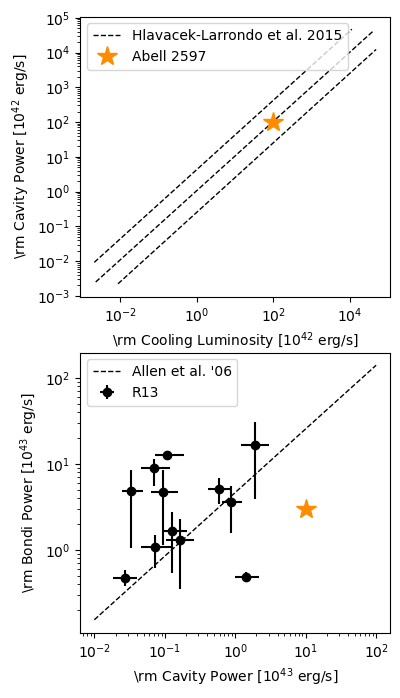

In [ ]:
nr, nc = 2, 1
#plot bondi power vs cavity power
fig, axes = plt.subplots(nr, nc, figsize=(nc*4,nr*4))
axs = axes.ravel()
ax = axs[0]
ax2 = axs[1]

h15_lcool = np.array([0.0058, 0.021, 0.092, 0.14, 0.108, 0.072, 0.052, 0.091, 0.109, 0.069, 0.069, 0.174, 0.269, 0.13, 0.308, 0.492, 0.637, 0.916, 0.9, 1.721, 1.522, 1.35, 3.398, 3.625, 5.45, 5.42, 10.318, 7.802, 27.454, 26.58, 320.413, 347.922, 446.148, 89.289, 95.791, 33.471, 23.874, 98.583, 103.341, 138.467, 202.264, 288.023, 288.023, 216.488, 411.41, 525.135, 629.676, 606.571, 1132.349, 1623.671, 433.185, 455.824, 2110.481, 3258.113, 2953.472])
h15_pcav = np.array([0.053, 0.60, 0.41, 0.58, 0.73, 1.04, 1.32, 3.01, 2.15, 6.00, 6.00, 4.73, 8.10, 13.49, 3.14, 1.01, 1.07, 1.61, 4.86, 3.91, 4.63, 11.35, 5.02, 13.97, 23.41, 32.53, 10.00, 6.17, 7.63, 20.38, 23.64, 38.33, 66.42, 97.72, 156.60, 683.27, 202.45, 415.98, 638.05, 261.34, 330.68, 453.84, 453.84, 779.65, 1265.70, 668.06, 419.06, 158.22, 94.85, 104.04, 6152.79, 7892.63, 1596.38, 1786.38, 6060.49])

# ax.plot(h15_lcool, h15_pcav, 'ko', label='Hlavacek-Larrondo et al. 2015')
ax.plot(h15_lcool_4pv, h15_pcav_4pv, lw=1, color='k', ls='--')
ax.plot(h15_lcool_16pv, h15_pcav_16pv, lw=1, color='k', ls='--', label='Hlavacek-Larrondo et al. 2015')
ax.plot(h15_lcool_1pv, h15_pcav_1pv, lw=1, color='k', ls='--')

ax.plot(a2597_lcool/1e42, pcav_sum/1e42,  '*', ms=15, color='darkorange', label='Abell 2597')


ax.set_xlabel(r'\rm Cooling Luminosity [$10^{42}$ erg/s]')
ax.set_ylabel(r'\rm Cavity Power [$10^{42}$ erg/s]')
ax.set_xscale('log')
ax.set_yscale('log')
    
ax.legend(fontsize=10)

ax2.plot(pcav_sum/1e43, a2597_pbondi/1e43, '*', ms=15, color='darkorange') #, label='Abell 2597')

#plot allen 06 law
sample_pcav = np.logspace(41, 45, 10)
log_pbondi_06 = 10**(0.67 + 0.74*np.log10(sample_pcav/1e43))
ax2.plot(sample_pcav/1e43, log_pbondi_06, 'k--', lw=1, label="Allen et al. '06")

#russell 2013 calculations
r13_pcav = np.array([0.0275, 0.0326, 0.0713, 0.0914, 0.1128, 0.0740, 0.1288, 0.1618, 0.5988, 0.8528, 1.9347, 1.3898])
r13_pbondi = np.array([0.4883, 4.7691, 8.6726, 4.7426, 12.5257, 1.0282, 1.6877, 1.2959, 5.2025, 3.5996, 16.4692, 0.5157])
ax2.errorbar(r13_xcav, r13_bondi, xerr=[r13_xcav - r13_xcav_low, r13_xcav_high - r13_xcav],
             yerr=[r13_bondi - r13_bondi_low, r13_bondi_high - r13_bondi], fmt='o', 
             color='k', label='R13')

#ax2.plot(r13_pcav, r13_pbondi, 'ko', label="Russell et al. '13")
ax2.set_xlabel(r'\rm Cavity Power [$10^{43}$ erg/s]')
ax2.set_ylabel(r'\rm Bondi Power [$10^{43}$ erg/s]')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.legend(fontsize=10)

### Bondi Power too low. Cold Fueling?

#### Timescale: Eddy turnover time

In [36]:
timescales_df = pd.DataFrame(np.load(specfit_savepath + 'byhand_timescales.npy'))

# #tcool/tedyy
# def t_eddy(r, l, vdisp):
#     return 2 * np.pi * np.power(r, 2./3.) * np.power(l, 1./3.) / vdisp
# l_mol = 30 * u.kpc
# l_cav = 30 * u.kpc
# vdisp_los_mol = 50 * u.km / u.s
# vdisp_3d_cav_perseus = 150 * u.km / u.s
# vdisp_3d_cav_sanders = 480 * u.km / u.s
# vdisp_3d_mol = vdisp_los_mol * np.sqrt(3)

# teddy = t_eddy(radius_to_plot, l_mol, vdisp_3d_mol).to(u.Gyr)
# teddy_cav_sanders =  t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_sanders).to(u.Gyr)

# tcool_teddy = cooling_time / teddy
# tcool_teddy_cav = cooling_time / teddy_cav_sanders

# teddy = t_eddy(radius_to_plot, l_mol, vdisp_3d_mol).to(u.Gyr)
# teddy_cav_sanders = t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_sanders).to(u.Gyr)
# teddy_cav_perseus = t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_perseus).to(u.Gyr)
# tcool_teddy = cooling_time / teddy
# tcool_teddy_cav_sanders = cooling_time / teddy_cav_sanders
# tcool_teddy_cav_perseus = cooling_time / teddy_cav_perseus

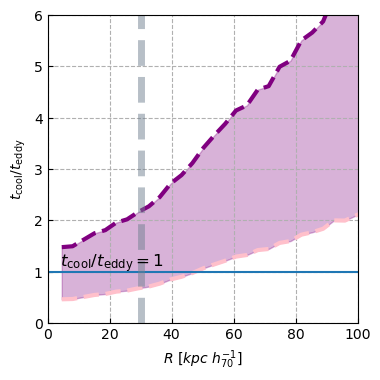

In [37]:
fig, ax4 = plt.subplots(figsize=(4,4))
#tcool / teddy
ax4.plot(timescales_df['radius'], timescales_df['tcool_teddy_cav_sanders'], lw=3, ls='--',color='purple')
ax4.plot(timescales_df['radius'], timescales_df['tcool_teddy_cav_perseus'], lw=3, ls='--',color='pink')
ax4.fill_between(timescales_df['radius'], 
                 timescales_df['tcool_teddy_cav_sanders'], 
                 timescales_df['tcool_teddy_cav_perseus'], 
                 color='purple', alpha=0.3) 

ax4.tick_params(axis="y",direction="in") #, pad=-22)
ax4.tick_params(axis="x",direction="in")#, pad=-15)

ax4.set_ylabel(r'$t_{\rm cool}/t_{\rm eddy}$')
ax4.axhline(1)
ax4.text(4, 1.1, r'$t_{\rm cool}/t_{\rm eddy} = 1$', fontsize=12, color='k', ha='left')
ax4.set_ylim(0,6)
ax4.set_xlim(0, 100)
ax4.axvline(30, color='slategray', ls='--', label=r"${Central}$ $60$ $kpc$", lw=5, alpha=0.5) # R_500 from the CCCPIV best fit. 
ax4.set_xlabel(r'$R$ $[kpc$ $h_{70}^{-1}]$')
ax4.grid(True, which='both', ls='--')


Kinematic Ratio Plot (k-plot)

In [38]:
def open_fits(filename, extension=0, naxis=None):
    """ Open FITS File

    Parameters:
        filename (str)
        extension (int): hdu extension
        naxis (int): for WCS

    Return:
        hdu, header, wcs
    """
    
    hdu = fits.open(filename)[extension] # Open the .fits file, return a list of Header/Data Units (HDUs). 
    hdr = hdu.header #The header of the data fits file and it tells you all technical info.
    w = WCS(hdr, naxis=naxis)
    return hdu, hdr, w

In [43]:
path_to_old_data = 'archival_data/'
valma_hdu, valma_hdr, valma_wcs = open_fits(path_to_old_data + 'ABELL2597_vel.fits')
vdalma_hdu, vdalma_hdr, vdalma_wcs = open_fits(path_to_old_data + 'ABELL2597_vdisp.fits')


In [41]:
def Classify_kplot(velocity_data, dispersion_data,  vres=40):
    """ Classify KPlot Spaxels
    kPlot - vLOS vs vdispersion
    """
    x, y = velocity_data.shape
    excitation = np.copy(velocity_data)
    log_vels, log_vdisp = [], []
    for i in range(x):
        for j in range(y):
            vel = np.log10(abs(velocity_data[i,j]))
            vdisp = np.log10(abs(dispersion_data[i,j] ))
            
            if np.isnan(vel) == True:
                excitation[i,j] = np.nan
                
            elif (vel < np.log10(vres)) or ( vdisp < np.log10(vres)):
                excitation[i,j] = np.nan
                
            elif ((vel > 1.6) & (vel < 3) & (vdisp> 1) & (vdisp < 3)):
                excitation[i,j] = 1
                log_vels.append(vel)
                log_vdisp.append(vdisp)
            else:
                excitation[i,j] = 2
                log_vels.append(vel)
                log_vdisp.append(vdisp)
                
                
    # excitation[

    
    return (log_vels, log_vdisp, excitation)

In [44]:
cold_ik, cold_jk, cold_exc = Classify_kplot(valma_hdu.data, vdalma_hdu.data)

/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_84026/2533508815.py:11: RuntimeWarning: divide by zero encountered in log10
  vdisp = np.log10(abs(dispersion_data[i,j] ))


/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_84026/2800306995.py:30: RuntimeWarning: divide by zero encountered in log10
  log_v_los = np.log10(v_los)
/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_84026/2800306995.py:31: RuntimeWarning: divide by zero encountered in divide
  log_v_los_err = v_los_err/v_los
/Users/osaseomoruyi/opt/anaconda3/envs/ciao-4.16/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


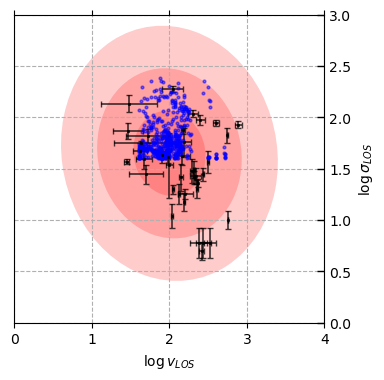

In [47]:
fig, ax1 = plt.subplots(figsize=(4,4))

# Gaspari+18 data
log_v_losG = 2.00
del_log_v_losG = 0.47
log_sigma_losG = 1.65
del_log_sigma_losG = 0.41
theta = 165.16
line_color='red'
sigma_los = np.array([191-13 , 42-8, 27-5 ,255-21 , 92-8 ,109-8, 85-6, 56-3, 18-2 ,119-8 ,175-15 ,94-10 ,
                      6-2 ,6-2 ,6-2 ,203-15 , 28-6 ,66-10 ,115-8, 33-4, 88-6 ,136-25 ,57-19 , 26-8 , 26-4 ,
                      23-2 , 15-3 , 20-2 ,5-1 ,126-25 , 76-7 ,73-13 ,67-11 ,47-8 , 43-8 , 41-5 , 39-8 , 37-2 ,
                      37-9 , 31-6 , 30-8 , 28-4 , 20-4 , 18-4 , 11-3 , 10-2, 34-25])
sigma_los_act = np.array([191,42,27,255,92,109,85,56,18,119,175,94,6,6,6,203, 28,66,115,33,88,136,57,26,26,23,
                          15,20,5,126,76,73,67,47,43,41,39,37,37,31,30,28,20,18,11,10,34])
sigma_los_err = sigma_los_act - sigma_los
log_sigma_los = np.log10(sigma_los_act)
log_sigma_los_err = sigma_los_err/np.abs(sigma_los_act)
v_los_min = np.array([-110 -35 , 145 -35 , 219 -35 , 0-30, 0-30, -200 -30 , -773 -80 ,43-35 ,160-35 , 0-30, 0-35 ,
                      250-35 ,240-60 ,275-60 ,335-60 , 0-35, 50-25 ,-53-35 , 0-35, 0-35, -399 -35 , -30 -25 , -155 -30 ,
                      140-8 ,210-4 ,-231-2 ,-155-3 ,111-2 , 260-20 , 0-26 ,-149-8 , 29 -13 , -557 -12 , 42-9 , -81-7 ,
                      -96-6 ,-47-11 , 28-2 ,-313-9 ,-207-7 , -193-7 ,-274-4 ,-227-4 ,-133-4 ,-108-3 ,-574-3, 100-10])
v_los_max = np.array([-110 +35 , 145 +35 , 219 +35 , 0+30, 0+30, -200 +30, -773 +80 ,43+35 ,160+35 , 0+30,
                      0+35 ,250+35 ,240+60 ,275+60 ,335+60 , 0+35 ,50+25 ,-53+35 , 0+35, 0+35, -399 +35 ,
                      -30 +25 , -155 +30 ,140+8 ,210+4 ,-231+2 ,-155+3 ,111+2 ,260+20 ,0+26 ,-149+8 , 29 +13 ,
                      -557 +12 ,42+9 ,-81+7 ,-96+6 ,-47+11 , 28+2 ,-313+9 ,-207+7 ,-193+7 ,-274+4 ,-227+4 ,
                      -133+4 ,-108+3 ,-574+3, 100+10])
v_los = np.abs((v_los_min + v_los_max)/2)
v_los_err = (v_los_max - v_los_min)/2
log_v_los = np.log10(v_los)
log_v_los_err = v_los_err/v_los

# Gaspari+18
ellipse1 = Ellipse(xy=(log_v_losG- .0, log_sigma_losG  - .0), width=2*del_log_v_losG, height=2*del_log_sigma_losG, angle=165.16,edgecolor='None', fc=line_color,alpha=0.2)
ellipse2 = Ellipse(xy=(log_v_losG- .0, log_sigma_losG  - .0), width=4*del_log_v_losG, height=4*del_log_sigma_losG, angle=165.16,edgecolor='None', fc=line_color,alpha=0.2)
ellipse3 = Ellipse(xy=(log_v_losG- .0, log_sigma_losG  - .0), width=6*del_log_v_losG, height=6*del_log_sigma_losG, angle=165.16,edgecolor='None', fc=line_color,alpha=0.2)


ax1.add_patch(ellipse3)
ax1.add_patch(ellipse2)
ax1.add_patch(ellipse1)
ax1.errorbar(log_v_los,log_sigma_los,xerr=0.434*log_v_los_err,yerr=0.434*log_sigma_los_err,fmt='s', markersize=1.2, elinewidth=1.2,color='k',capsize=2,alpha=0.75,label='Gaspari+18')
ax1.grid(True, which='both', ls='--')

ax1.plot(cold_ik, cold_jk, '.b', alpha=0.5, ms = 4)

ax1.set_xlim(0,4)
ax1.set_ylim(0,3)

ax1.set_xlabel('$\log v_{LOS}$')
ax1.set_ylabel('$\log \sigma_{LOS}$')

ax1.tick_params(axis='y', which='both', direction='in', length=5, width=1, color='black', labelleft=False, labelright=True)
ax1.yaxis.set_ticks_position('right')
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_label_position('right')


## Shocks

In [10]:
width = 1 #arcsec
sb_majors = ([32.112, 62.610, 98.746] * u.arcsec * kpc_per_arcsec ).to(u.kpc)
sb_majors_outer = ([32.112 + width, 62.610+ width, 98.746 + width] * u.arcsec * kpc_per_arcsec ).to(u.kpc)
sb_minors = ([27.570, 54.403, 80.060] * u.arcsec * kpc_per_arcsec ).to(u.kpc)
sb_minors_outer = ([27.570 + width, 54.403 + width, 80.060 + width] * u.arcsec * kpc_per_arcsec ).to(u.kpc)

### Compute Mach Number

In [9]:
def mach_from_density_jump(rho_jump, gamma=5/3):
    """
    Compute the Mach number from the density jump across a shock.
    - M: Mach number
    """
    if rho_jump <= 1:
        raise ValueError("Density jump must be greater than 1 for a shock.")

    M_sq = -2 * rho_jump / (rho_jump * gamma - rho_jump - gamma - 1)#((rho_jump - 1) * (gamma - 1) + 2) / (gamma + 1)\
    M = np.sqrt(M_sq)
    return M

#density jumps taken from pyproffit
mach_e1 = mach_from_density_jump(1.17)
mach_e2 = mach_from_density_jump(1.11)
mach_e3 = mach_from_density_jump(1.21)

print(f'Mach number at SB Edge 1: {mach_e1:.2f}')
print(f'Mach number at SB Edge 2: {mach_e2:.2f}')
print(f'Mach number at SB Edge 3: {mach_e3:.2f}')

Mach number at SB Edge 1: 1.11
Mach number at SB Edge 2: 1.07
Mach number at SB Edge 3: 1.14


### Energy

In [13]:
#load spectral fits
big_spectral_edges = pd.DataFrame(np.load("/Users/osaseomoruyi/Dropbox (Harvard University)/Abell_2597/analysis/ChandraA2597/analysis/data/spectral_fitting_results/careful_fit_run_020425_spectral_cocoon_shocks.npy"))
fine_spectral_edges = pd.DataFrame(np.load("/Users/osaseomoruyi/Dropbox (Harvard University)/Abell_2597/analysis/ChandraA2597/analysis/data/spectral_fitting_results/careful_fit_run_020425_fine_spectral_cocoon_shocks.npy"))

def calc_wedge_pressure(table, angle_start=218.21832, angle_end=256.09284):
    
    r_outer = table['r_outer'].to_numpy() * u.kpc
    r_inner = table['r_inner'].to_numpy() * u.kpc
    angle_wedge = (angle_end - angle_start)/360
    volume = abs((4/3) * np.pi * (r_outer**3 - r_inner**3)) * angle_wedge

    ne = np.sqrt((table['norm'].to_numpy() * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + z), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 
    
    ne_err = abs(ne / (2 * table['norm'].to_numpy()) * table['norm_up_err'].to_numpy()).to(u.cm**-3)

    pressure = (2 * ne * table['kT'].to_numpy() * u.keV).to(u.dyne/u.cm**2)
    pressure_err = pressure * np.sqrt((ne_err/ne)**2 + (table['kT_up_err'].to_numpy()/table['kT'].to_numpy())**2)

    entropy = table['kT'].to_numpy() * u.keV * np.power(ne, -2.0/3.0)
    entropy_err = entropy * np.sqrt((table['kT_up_err'].to_numpy()/table['kT'].to_numpy())**2 + (2/3) * (ne_err/ne)**2)

    return pressure, pressure_err, volume, entropy, entropy_err

pressure_big, epb, volume_big, entropy_big, eeb = calc_wedge_pressure(big_spectral_edges)
pressure_fine, epf, volume_fine, entropy_fine, eef = calc_wedge_pressure(fine_spectral_edges)



In [14]:
#calculate shok energy
def shock_energy(mach_number, pressure_pre_shock, volume):
    return (pressure_pre_shock * volume * (mach_number - 1)).to(u.erg)


volume_shocks = 4./3. * np.pi * ( (sb_majors_outer * sb_minors_outer**2) - (sb_majors * sb_minors**2) )              

pressure_s1 = pressure_big[1]
shock_energy_s1 = shock_energy(mach_e1, pressure_s1, volume_shocks[0])

pressure_s2 = pressure_big[3]
shock_energy_s2 = shock_energy(mach_e2, pressure_s2, volume_shocks[1])

pressure_s3 = pressure_big[5]
shock_energy_s3 = shock_energy(mach_e3, pressure_s3, volume_shocks[2])

print(f'Shock energy at SB Edge 1: {shock_energy_s1:.2e}')
print(f'Shock energy at SB Edge 2: {shock_energy_s2:.2e}')
print(f'Shock energy at SB Edge 3: {shock_energy_s3:.2e}')
print(f'Total shock energy across the 3 fronts is: {shock_energy_s1 + shock_energy_s2 + shock_energy_s3:.2e}')

Shock energy at SB Edge 1: 4.26e+58 erg
Shock energy at SB Edge 2: 3.48e+58 erg
Shock energy at SB Edge 3: 6.29e+58 erg
Total shock energy across the 3 fronts is: 1.40e+59 erg


In [15]:
# Constants
gamma = 5 / 3  # Adiabatic index for a monatomic gas

# Data from Table 2
shocks = {
    "Inner": {"M": 1.11},
    "Middle": {"M": 1.07},
    "Outer": {"M": 1.14},
}

def entropy_change(mach, gamma=5/3):
    """
    Compute the entropy increase Δln(P/ρ^γ) across a shock.

    Parameters:
    - P_jump: Pressure jump ratio (P2/P1)
    - rho_jump: Density jump ratio (ρ2/ρ1)
    - gamma: Adiabatic index (default is 5/3 for a monatomic gas)

    Returns:
    - Delta_ln_S: Entropy increase (logarithmic change in P/ρ^γ)
    """

    P_jump = 1 + (2 * gamma / (gamma + 1)) * (mach**2 - 1)
    rho_jump = (gamma + 1) * mach**2 / (2 + (gamma - 1) * mach**2)

    delta_ln_S = np.log(P_jump) - gamma * np.log(rho_jump)

    # Compute number of shocks needed to offset cooling
    num_shocks_needed = 1 / delta_ln_S
    
    return delta_ln_S, num_shocks_needed


# Compute and print results
print(f"{'Shock Region':<15} {'Δln(P/ρ^γ)':<15} {'Shocks Needed':<15}")
print("="*45)

for name, values in shocks.items():
    delta_ln_S, num_shocks_needed = entropy_change(values["M"])
    print(f"{name:<15} {delta_ln_S*100:.1f}% {num_shocks_needed:.1f}")

Shock Region    Δln(P/ρ^γ)      Shocks Needed  
Inner           0.1% 1137.7
Middle          0.0% 4069.7
Outer           0.2% 585.3


In [29]:
shock_energies = np.array([3, 5, 10]) * 1e58 * u.erg
shock_ages = [50, 80, 100] * u.Myr

shock_powers = (shock_energies / shock_ages).to(u.erg/u.s)
shock_powers

<Quantity [1.90128527e+43, 1.98050549e+43, 3.16880878e+43] erg / s>